In [ ]:
import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import argparse, sys
import numpy as np
import datetime
import shutil

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

from torch_geometric.datasets import CitationFull
import torch_geometric.utils as utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 3.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.4 MB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 3.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

**Graph Conv Layer Forward Pass**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from torch_geometric.nn import GCNConv
import numpy as np
import scipy.sparse as sp
from torch_geometric.utils import from_scipy_sparse_matrix


class GraphConvLayer(nn.Module):
    def __init__(self, in_feature, out_feature, no_class, dropout=0.6, lr=0.001, weight_decay=6e-4,device=None):

        super(GraphConvLayer, self).__init__()

        # Iteration number for DualGraph is 2
        self.device = device
        self.in_feature = in_feature
        self.out_feature = [out_feature]
        self.no_class = no_class
        self.lr = lr
        self.weight_decay = weight_decay
        self.edge_index = None
        self.edge_weight = None
        self.features = None
        
        self.gcn1 = GCNConv(in_feature, out_feature, bias=True,add_self_loops=True)
        self.gcn2 = GCNConv(out_feature, no_class, bias=True,add_self_loops=True)

        self.dropout = dropout

        # Conv_ReLu_BN mapping from Rm to R1
        self.conv_layer =nn.Conv2d(in_feature,128,kernel_size=3,stride=1, padding=1)
        self.BN = nn.BatchNorm2d(128)


    def forward(self, x, edge_index, edge_weight):
        #trans_net = self.dropout(F.relu(self.BN(self.conv_layer(x))))
        x = F.relu(self.gcn1(x, edge_index,edge_weight),inplace = False)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gcn2(x, edge_index,edge_weight)

        return x

**Adding Noise For Noisy Labels**

In [ ]:
import numpy as np
from numpy.testing import assert_array_almost_equal
import torch

# %%
def acc(output, labels):
    if not hasattr(labels, '__len__'):
        labels = [labels]
    if type(labels) is not torch.Tensor:
        labels = torch.LongTensor(labels)
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def ConstructPairMatrix(size, noise):
    assert(noise >= 0.) and (noise <= 1.)
    PairMatrix = (1.0 - np.float64(noise)) * np.eye(size)
    for i in range(size):
        PairMatrix[i,i-1] = np.float64(noise)
    assert_array_almost_equal(PairMatrix.sum(axis=1), 1, 1)
    return PairMatrix


def ConstructUniforMatrix(size, noise):
    assert(noise >= 0.) and (noise <= 1.)

    UniformMatrix = np.float64(noise) / np.float64(size - 1) * np.ones((size, size))
    np.fill_diagonal(UniformMatrix, (np.float64(1)-np.float64(noise))*np.ones(size))
    
    diag_idx = np.arange(size)
    UniformMatrix[diag_idx,diag_idx] = UniformMatrix[diag_idx,diag_idx] + 1.0 - UniformMatrix.sum(0)
    assert_array_almost_equal(UniformMatrix.sum(axis=1), 1, 1)
    return UniformMatrix

def AddNoiseForMultClass(inp, NoiseMatrix, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    """

    assert NoiseMatrix.shape[0] == NoiseMatrix.shape[1]
    assert np.max(inp) < NoiseMatrix.shape[0]

    # row stochastic matrix
    assert_array_almost_equal(NoiseMatrix.sum(axis=1), np.ones(NoiseMatrix.shape[1]))
    assert (NoiseMatrix >= 0.0).all()

    m = inp.shape[0]
    out = inp.copy()
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = inp[idx]
        flipped = flipper.multinomial(1, NoiseMatrix[i, :], 1)[0]
        out[idx] = np.where(flipped == 1)[0]
    return out

def Add_noise(train_inp, no_classes, noise, random_state=None,  noise_type='uniform'):
    if noise > 0.0:
        if noise_type=='pair':
            NoiseMatrix = ConstructPairMatrix(no_classes, noise)
        elif noise_type == 'uniform':
            NoiseMatrix = ConstructUniforMatrix(no_classes, noise)
        noisy_train_inp = AddNoiseForMultClass(train_inp, NoiseMatrix=NoiseMatrix,
                                           random_state=random_state)
        actual_noise = (noisy_train_inp != train_inp).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        train_inp = noisy_train_inp
    else:
        NoiseMatrix = np.eye(no_classes)

    return train_inp, NoiseMatrix

**Our Model For DualGraph**

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy

import numpy as np
import scipy.sparse as sp
from torch_geometric.utils import from_scipy_sparse_matrix

class CELogLoss(nn.Module):

    def __init__(self, nclass):
        super(CELogLoss, self).__init__()
        P = torch.FloatTensor(ConstructUniforMatrix(nclass,0.1))
        self.B = torch.nn.parameter.Parameter(torch.log(P))
    
    def forward(self, pred):
        P = F.softmax(self.B, dim=1)
        return pred @ P

class DualGraph(nn.Module):
    """ 2 Layer Graph Convolutional Network.
    """
    def __init__(self, in_feature, out_feature, no_class, dropout=0.51, lr=0.012, weight_decay=6e-4,device=None):

        super(DualGraph, self).__init__()
        assert device is not None, "Please specify 'device'!"
        self.device = device
        self.in_feature = in_feature
        self.out_feature = [out_feature]
        self.no_class = no_class
        self.lr = lr
        self.weight_decay = weight_decay
        self.edge_index = None
        self.edge_weight = None
        self.features = None

        self.loss_log = CELogLoss(no_class)
        self.dropout = dropout
        self.GCN1 = GraphConvLayer(in_feature,out_feature,no_class,dropout,device=device)
        self.GCN2 = GraphConvLayer(in_feature,out_feature,no_class,dropout,device=device)

    def forward(self, x, edge_index, edge_weight):

        return self.GCN1(x,edge_index,edge_weight), self.GCN2(x,edge_index,edge_weight)

    def fit(self, features, adj, labels, train_index, valid_index=None, noise_rate=0.19, ek=10,train_iters=205, verbose=True):

        self.edge_index, self.edge_weight = from_scipy_sparse_matrix(adj)
        self.edge_index, self.edge_weight = self.edge_index.to(self.device), self.edge_weight.float().to(self.device)

        if sp.issparse(features):
            features = utils.sparse_mx_to_torch_sparse_tensor(features).to_dense().float()
        else:
            features = torch.FloatTensor(np.array(features))
        self.features = features.to(self.device)
        self.labels = torch.LongTensor(np.array(labels)).to(self.device)

        self.noise_rate = noise_rate
        loss = self.Train(self.labels, train_index, valid_index, ek ,train_iters, verbose)
        return loss
    def Train(self, labels, train_index, idx_val, ek,train_iters, verbose):
        loss_arr = []
        if verbose:
            print('=== training gcn model ===')
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        best_loss_val = 100
        best_acc_val = 0
        train_index = np.asarray(train_index)

        for i in range(train_iters):
            self.train()
            optimizer.zero_grad()
            out_1, out_2 = self.forward(self.features, self.edge_index, self.edge_weight)

            prediction_1 = out_1[train_index].max(1)[1]
            prediction_2 = out_2[train_index].max(1)[1]

            disagree = (prediction_1 != prediction_2).cpu().numpy()
            idx_update = train_index[disagree]

            if len(idx_update) == 0:
                break

            prediction_1 = F.softmax(out_1,dim=1)
            prediction_2 = F.softmax(out_2,dim=1)
            eps = 1e-8
            score_1 = self.loss_log(prediction_1).clamp(eps,1-eps)
            score_2 = self.loss_log(prediction_2).clamp(eps,1-eps)

            loss_1 = F.cross_entropy(torch.log(score_1[idx_update]), self.labels[idx_update])
            loss_2 = F.cross_entropy(torch.log(score_2[idx_update]), self.labels[idx_update])

            train_loss = loss_1.mean() + loss_2.mean()
            train_loss.backward()
            optimizer.step()
            nloss = train_loss.detach().numpy()
            loss_arr.append(nloss.item())
            self.eval()
            output1, output2 = self.forward(self.features, self.edge_index, self.edge_weight)
            acc_val = max(acc(output1[idx_val], labels[idx_val]),acc(output2[idx_val], labels[idx_val]))
            if acc_val > best_acc_val:
                best_acc_val = acc_val
                weights = deepcopy(self.state_dict())
            if verbose and i % 1 == 0:
                print('Epoch {}, training loss: {}, acc_val: {:.4f}'.format(i, train_loss.item(),acc_val))

        if verbose:
            print('=== picking the best model according to the performance on validation ===')
        self.load_state_dict(weights)
        return loss_arr

    def Test(self, test_index):
        self.eval()
        out1, out2 = self.forward(self.features, self.edge_index, self.edge_weight)
        accuracy_1 = acc(out1[test_index], self.labels[test_index])
        accuracy_2 = acc(out2[test_index], self.labels[test_index])
        print("Test set results:",
              "acc_1= {:.4f}".format(accuracy_1.item()),
              "acc_2= {:.4f}".format(accuracy_2.item()))
        return out1,out2


# %%

**Main Code**

In [137]:
import time
import argparse
import numpy as np
import torch

# Parameters for the Training Session
parser = argparse.ArgumentParser()
parser.add_argument('--ek', type=int, default=50)
parser.add_argument('--no-cuda', action='store_true', default=False)
parser.add_argument('--epochs', type=int,  default=500)
parser.add_argument("--label_rate", type=float, default=0.069)
parser.add_argument('--ptb_rate', type=float, default=0.19)
parser.add_argument('--dropout', type=float, default=0.6)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--debug', action='store_true',default=False)
parser.add_argument('--seed', type=int, default=11)
parser.add_argument('--weight_decay', type=float, default=6e-4)
parser.add_argument('--hidden', type=int, default=20)
parser.add_argument('--dataset', type=str, default='dplb',choices=['cora', 'cora_ml', 'citeseer', 'polblogs', 'pubmed','dblp'])
parser.add_argument('--noise', type=str, default='uniform',choices=['uniform', 'pair'])
args = parser.parse_known_args()[0]
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

if args.cuda:
    torch.cuda.manual_seed(args.seed)
print(args)

np.random.seed(15) 


from torch_geometric.datasets import CitationFull
import torch_geometric.utils as torch_utils

dataset = CitationFull('./data','dblp')
adj = torch_utils.to_scipy_sparse_matrix(dataset.data.edge_index)

labels = dataset.data.y.numpy()
features = dataset.data.x.numpy()
index = np.arange(len(labels))
np.random.shuffle(index)

valid_index = index[int(0.8 * len(labels)):int(0.9 * len(labels))]
train_index = index[int(0.9 * len(labels)):int((0.9+args.label_rate) * len(labels))]
test_index = index[:int(0.8 * len(labels))]


ptb = args.ptb_rate
no_class = labels.max() + 1
Train_data = labels[train_index]
noisy_out, _ = Add_noise(Train_data,no_class, ptb,10, args.noise)
noisy_labels = labels.copy()
noisy_labels[train_index] = noisy_out

np.random.seed(args.seed)
torch.manual_seed(args.seed)

model = DualGraph(in_feature=features.shape[1],
            out_feature=args.hidden,
            no_class=labels.max().item() + 1,
            dropout=args.dropout, device=device).to(device)

#%%
train_loss = model.fit(features, adj, noisy_labels, train_index, valid_index,train_iters=205, ek=args.ek,verbose=args.debug)
model.Test(test_index)


Namespace(cuda=False, dataset='dplb', debug=False, dropout=0.6, ek=50, epochs=500, hidden=20, label_rate=0.069, lr=0.01, no_cuda=False, noise='uniform', ptb_rate=0.19, seed=11, weight_decay=0.0006)
Actual noise 0.18
Test set results: acc_1= 0.7948 acc_2= 0.8025


(tensor([[ 0.1342,  0.7117, -0.3678, -0.2778],
         [ 0.2525,  0.5993, -0.4415, -0.1878],
         [ 0.0897,  0.6830, -0.2571, -0.2657],
         ...,
         [ 0.3589,  0.2860, -0.3128, -0.4767],
         [ 0.2239,  0.2602, -0.3767, -0.1291],
         [ 0.2544,  0.0280, -0.3141, -0.0533]], grad_fn=<AddBackward0>),
 tensor([[-0.3050,  0.3632, -0.2144, -0.3986],
         [-0.1551,  0.1421, -0.3134, -0.4124],
         [-0.2900,  0.3383, -0.1037, -0.4785],
         ...,
         [ 0.2470, -0.2791,  0.0032, -0.5151],
         [ 0.0539, -0.1170, -0.4240, -0.1629],
         [ 0.2377, -0.2898, -0.4556,  0.0070]], grad_fn=<AddBackward0>))

[2.771407127380371, 2.7185723781585693, 2.68304443359375, 2.6371893882751465, 2.614102602005005, 2.5911307334899902, 2.569585084915161, 2.52734112739563, 2.5047779083251953, 2.492724895477295, 2.4809961318969727, 2.4274845123291016, 2.4011499881744385, 2.3619868755340576, 2.3574657440185547, 2.3137640953063965, 2.3038759231567383, 2.310542106628418, 2.293320655822754, 2.26369047164917, 2.2074379920959473, 2.223210334777832, 2.2091658115386963, 2.2444875240325928, 2.2271885871887207, 2.1437017917633057, 2.1250529289245605, 2.103742837905884, 2.0566248893737793, 2.1025197505950928, 2.0932512283325195, 2.0892581939697266, 2.094792366027832, 2.0560669898986816, 2.0818634033203125, 1.9782166481018066, 2.0120034217834473, 2.0682883262634277, 1.9140406847000122, 1.9084999561309814, 1.9071736335754395, 2.0161280632019043, 1.9627397060394287, 1.9702730178833008, 1.8561146259307861, 2.0174145698547363, 1.8837605714797974, 1.9235773086547852, 1.916717529296875, 1.9758617877960205, 1.8480014801025

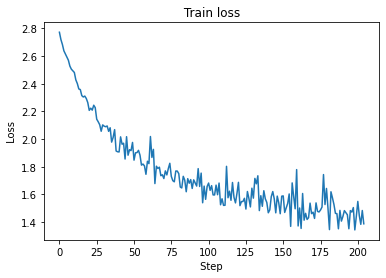

In [139]:
import matplotlib.pyplot as plt # For plotting
print(train_loss)
plt.plot(train_loss)
plt.title(" Train loss ")
plt.xlabel(" Step ")
plt.ylabel(" Loss ")
plt.show()
pass
